# This notebook is for modeling both scan directions together and calculating the chisquare statistic for 1, 2, and 3-T models

In [2]:
from preamble import *

  0%|          | 0/2 [00:00<?, ?it/s]

# 1T BT-SETTL Model

Processing F21 (both directions)

Running MCMC sampler...


100%|██████████| 2000/2000 [08:37<00:00,  3.86it/s]


(Nsteps-burnin)*nwalkers/tau= 108
(Nsteps-burnin)*nwalkers/tau= 101
(Nsteps-burnin)*nwalkers/tau= 1641


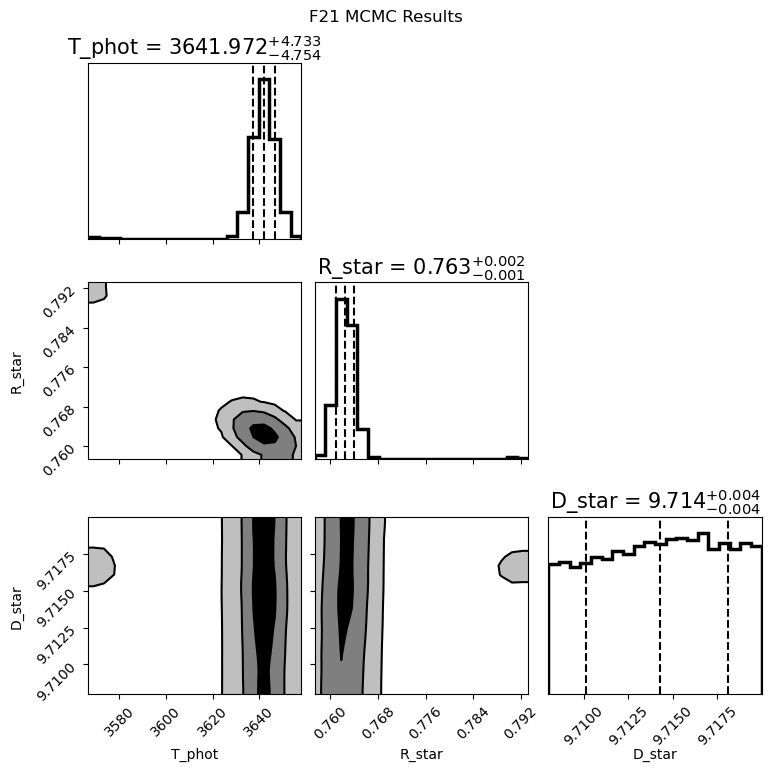

T_phot:
  Median (50th percentile): 3641.97
  Lower 1-sigma uncertainty: 4.8
  Upper 1-sigma uncertainty: 4.8

R_star:
  Median (50th percentile): 0.76
  Lower 1-sigma uncertainty: 0.002
  Upper 1-sigma uncertainty: 0.002

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 1070.41
Combined Reduced Chi-squared: 4.93
Combined Degrees of Freedom: 217


Processing S22 (both directions)

Running MCMC sampler...


100%|██████████| 2000/2000 [08:27<00:00,  3.94it/s]


(Nsteps-burnin)*nwalkers/tau= 121
(Nsteps-burnin)*nwalkers/tau= 121
(Nsteps-burnin)*nwalkers/tau= 1947


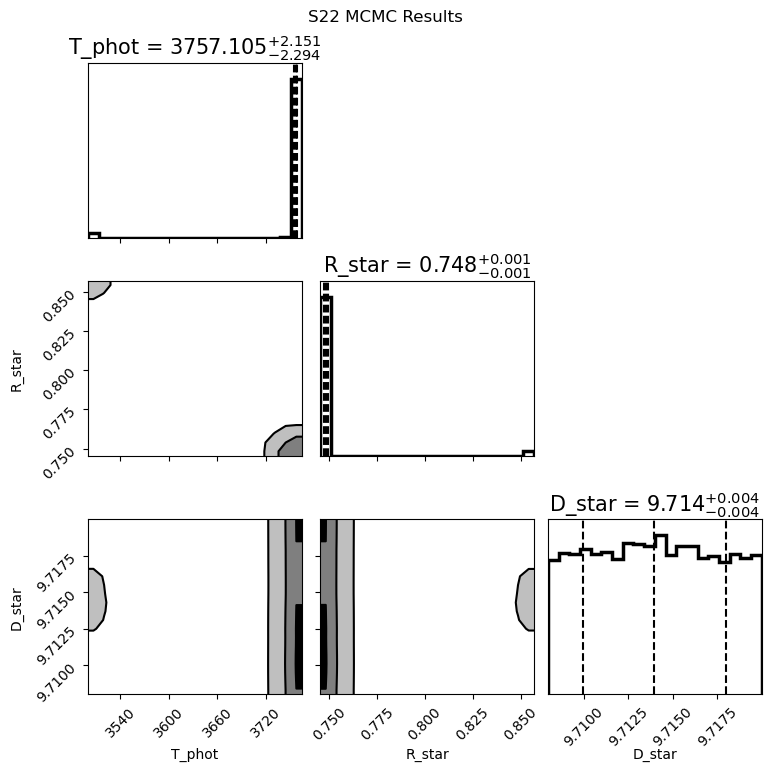

T_phot:
  Median (50th percentile): 3757.11
  Lower 1-sigma uncertainty: 2.3
  Upper 1-sigma uncertainty: 2.2

R_star:
  Median (50th percentile): 0.75
  Lower 1-sigma uncertainty: 0.001
  Upper 1-sigma uncertainty: 0.001

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 1766.55
Combined Reduced Chi-squared: 7.09
Combined Degrees of Freedom: 249




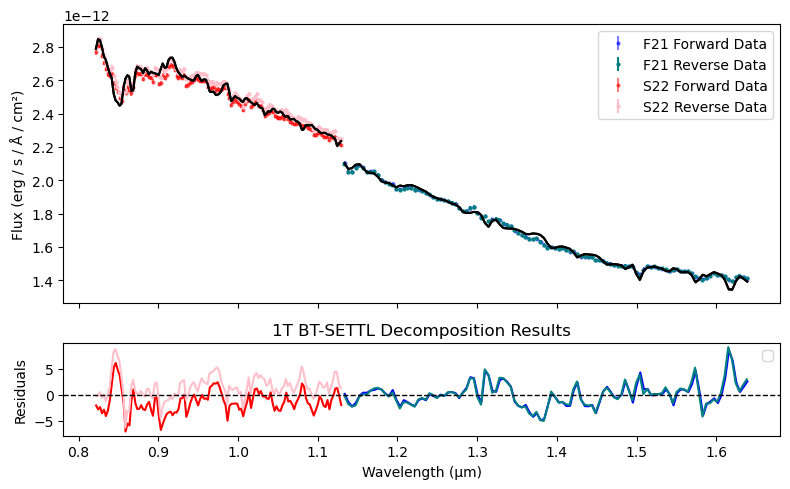

In [10]:
def lnprob(parameters=None,**kwargs):

    T_phot, R_star, D_star = parameters
    ln_like = 0

    # Boundary conditions for parameters to ensure physical validity
    c1 = (3300 <= T_phot <= 4200)
    c2 = (0.7 <= R_star <= 0.88)
    c3 = (9.708 <= D_star <= 9.720)
    if (c1 and c2 and c3):
        
        # Set parameters in lmfit
        model_params = lmfit.Parameters()
        model_params.add('T_phot', value=T_phot)
        model_params.add('R_star', value=R_star)
        model_params.add('D_star', value=D_star)
        solid_angle = (( (R_star * u.R_sun)/(D_star*u.parsec) ).decompose() )**2

        for direction in ['Forward','Reverse']:
            data_flux = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['f']
            data_wave= WFC3_Median_Spectra[f'{visit}'][f'{direction}']['w']
            data_err = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['e']
    
            # Generate model based on these parameters for both scan directions
            _model_flux = bintogrid(btsettl_wavelengths, spectral_model(model_params, filter_sigma), newx=data_wave.value)['y']
            model_flux = _model_flux * solid_angle
            # Calculate residuals and log-likelihood for both directions
            residuals = data_flux.value - model_flux
            err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err.value)))

            ln_like += (err_weight - 0.5*np.nansum((residuals / data_err.value) ** 2) )
            
        return ln_like

    else:
        return -np.inf  # Return log-probability of -inf outside bounds

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 1
speclibrary = 'btsettl'
spectral_model = btsettl_1T
nwalkers = 100
nsteps = 2000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    wave_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['w']
    wave_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['w']
    flux_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['f']
    flux_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['f']
    err_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['e']
    err_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['e']

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(wave_fwd.value)
    all_data['calibrated_flux'].append(flux_fwd.value)
    all_data['calibrated_flux_err'].append(err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(wave_rev.value)
    all_data['calibrated_flux'].append(flux_rev.value)
    all_data['calibrated_flux_err'].append(err_rev.value)

    # MCMC setup
    """EDIT THESE LINES"""
    Tphot_init = np.random.uniform(3600,3750,nwalkers)
    Rstar_init = np.random.uniform(0.7, 0.9, nwalkers)
    Dstar_init = np.random.uniform(9.712, 9.716, nwalkers)
    p0 = np.transpose([Tphot_init, Rstar_init, Dstar_init])

    ndim = 3
    burnin = int(0.5*nsteps)
    """"""""""""""""""""""""
    
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob, 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    # Make corner plot
    rng = 0.9995
    """EDIT THESE LINES"""
    variable_names = ['T_phot', 'R_star', 'D_star']
    """"""""""""""""""""""""
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    """EDIT THESE LINES"""
    T_phot_sam, R_star_sam, D_star_sam = samples
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    sig1_D_star = np.percentile(D_star_sam, [15.9, 50., 84.1])

    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("T_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    print("\nD_star:")
    print(f"  Median (50th percentile): {sig1_D_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_D_star[1] - sig1_D_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_D_star[2] - sig1_D_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])
    mcmc_model_params.add('D_star', value=sig1_D_star[1])
    """"""""""""""""""""""""

    # Calculate the max likelihood model for both scan directions
    solid_angle = (( (sig1_R_star[1] * u.R_sun)/(sig1_D_star[1]*u.parsec) ).decompose() )**2
    best_model = spectral_model(mcmc_model_params, filter_sigma) * solid_angle    
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(btsettl_wavelengths, best_model, newx=wave_fwd.value)['y']
    model_flux_mcmc_rev = bintogrid(btsettl_wavelengths, best_model, newx=wave_rev.value)['y']

    # Calculate residuals for both scan directions
    residuals_fwd = flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = flux_rev.value - model_flux_mcmc_fwd
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / err_fwd.value,
        residuals_rev / err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(flux_fwd.value) + len(flux_rev.value)
    dof_combined = total_data_points - ndim
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

# Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]
plt.title(f'{ncomponents}T BT-SETTL Decomposition Results')

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()

# 1T PHOENIX Model

Processing F21 (both directions)

Running MCMC sampler...


100%|██████████| 2000/2000 [08:11<00:00,  4.07it/s]


(Nsteps-burnin)*nwalkers/tau= 2493
(Nsteps-burnin)*nwalkers/tau= 2478
(Nsteps-burnin)*nwalkers/tau= 2136


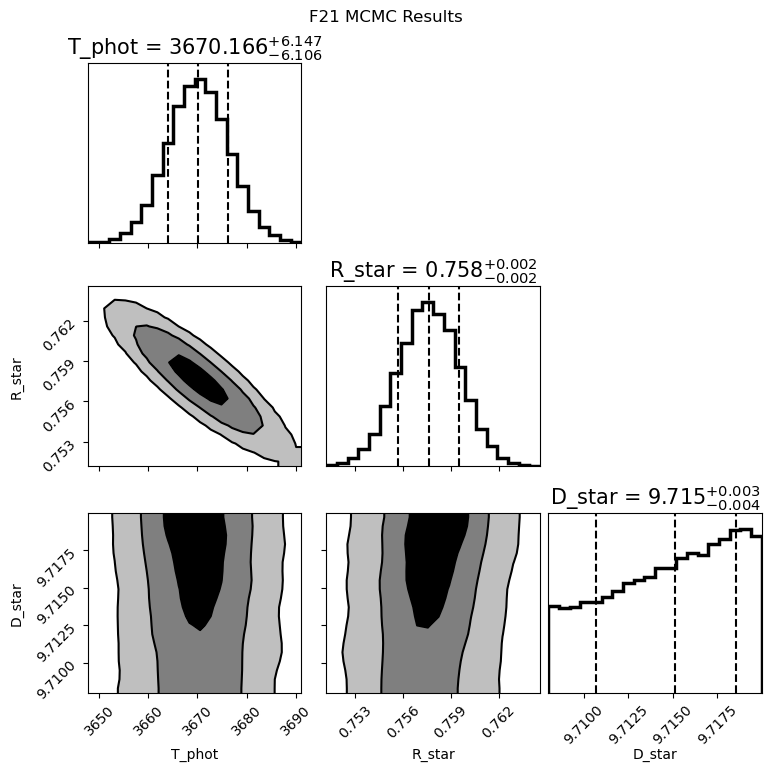

T_phot:
  Median (50th percentile): 3670.17
  Lower 1-sigma uncertainty: 6.1
  Upper 1-sigma uncertainty: 6.2

R_star:
  Median (50th percentile): 0.76
  Lower 1-sigma uncertainty: 0.002
  Upper 1-sigma uncertainty: 0.002

D_star:
  Median (50th percentile): 9.72
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.003
Combined Chi-squared: 819.95
Combined Reduced Chi-squared: 3.78
Combined Degrees of Freedom: 217


Processing S22 (both directions)

Running MCMC sampler...


100%|██████████| 2000/2000 [08:38<00:00,  3.86it/s]


(Nsteps-burnin)*nwalkers/tau= 2601
(Nsteps-burnin)*nwalkers/tau= 2689
(Nsteps-burnin)*nwalkers/tau= 2212


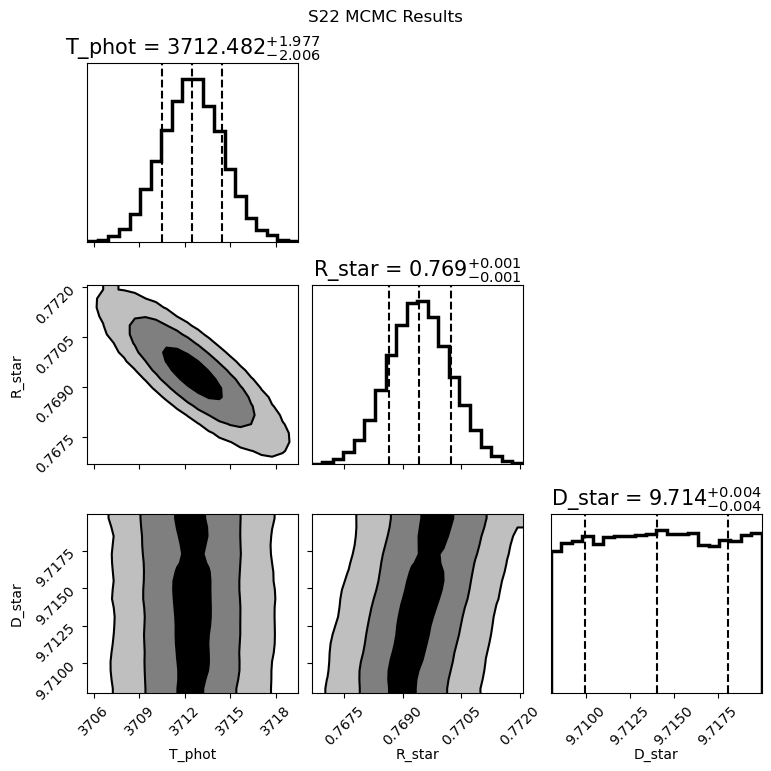

T_phot:
  Median (50th percentile): 3712.48
  Lower 1-sigma uncertainty: 2.0
  Upper 1-sigma uncertainty: 2.0

R_star:
  Median (50th percentile): 0.77
  Lower 1-sigma uncertainty: 0.001
  Upper 1-sigma uncertainty: 0.001

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 1721.57
Combined Reduced Chi-squared: 6.91
Combined Degrees of Freedom: 249




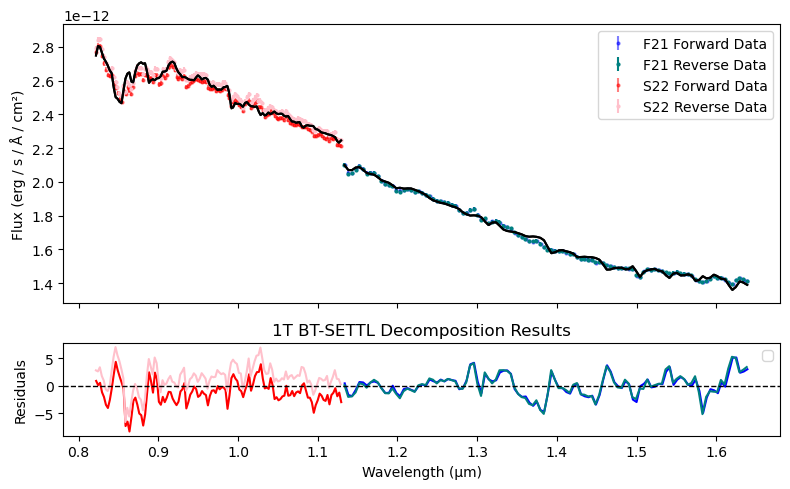

In [9]:
def lnprob(parameters=None,**kwargs):

    T_phot, R_star, D_star = parameters
    ln_like = 0

    # Boundary conditions for parameters to ensure physical validity
    c1 = (3300 <= T_phot <= 4200)
    c2 = (0.7 <= R_star <= 0.88)
    c3 = (9.708 <= D_star <= 9.720)
    
    if (c1 and c2 and c3 ):
        
        # Set parameters in lmfit
        model_params = lmfit.Parameters()
        model_params.add('T_phot', value=T_phot)
        model_params.add('R_star', value=R_star)
        model_params.add('D_star', value=D_star)
        solid_angle = (( (R_star * u.R_sun)/(D_star*u.parsec) ).decompose() )**2

        for direction in ['Forward','Reverse']:
            data_flux = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['f']
            data_wave= WFC3_Median_Spectra[f'{visit}'][f'{direction}']['w']
            data_err = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['e']
    
            # Generate model based on these parameters for both scan directions
            _model_flux = bintogrid(model_wavelengths.value, spectral_model(model_params, filter_sigma), newx=data_wave.value)['y']
            model_flux = _model_flux * solid_angle
            # Calculate residuals and log-likelihood for both directions
            residuals = data_flux.value - model_flux
            err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err.value)))

            ln_like += (err_weight - 0.5*np.nansum((residuals / data_err.value) ** 2) )
            
        return ln_like

    else:
        return -np.inf  # Return log-probability of -inf outside bounds

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 1
speclibrary = 'phoenix'
spectral_model = phoenix_1T
nwalkers = 100
nsteps = 2000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    wave_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['w']
    wave_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['w']
    flux_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['f']
    flux_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['f']
    err_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['e']
    err_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['e']

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(wave_fwd.value)
    all_data['calibrated_flux'].append(flux_fwd.value)
    all_data['calibrated_flux_err'].append(err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(wave_rev.value)
    all_data['calibrated_flux'].append(flux_rev.value)
    all_data['calibrated_flux_err'].append(err_rev.value)

    # MCMC setup
    """EDIT THESE LINES"""
    Tphot_init = np.random.uniform(3600,3750,nwalkers)
    Rstar_init = np.random.uniform(0.7, 0.9, nwalkers)
    Dstar_init = np.random.uniform(9.712, 9.716, nwalkers)
    p0 = np.transpose([Tphot_init, Rstar_init, Dstar_init])

    ndim = 3
    burnin = int(0.5*nsteps)
    """"""""""""""""""""""""
    
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob, 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    # Make corner plot
    rng = 0.9995
    """EDIT THESE LINES"""
    variable_names = ['T_phot', 'R_star', 'D_star']
    """"""""""""""""""""""""
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    """EDIT THESE LINES"""
    T_phot_sam, R_star_sam, D_star_sam = samples
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    sig1_D_star = np.percentile(D_star_sam, [15.9, 50., 84.1])
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("T_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    print("\nD_star:")
    print(f"  Median (50th percentile): {sig1_D_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_D_star[1] - sig1_D_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_D_star[2] - sig1_D_star[1]:.3f}")
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])
    mcmc_model_params.add('D_star', value=sig1_D_star[1])
    """"""""""""""""""""""""

    # Calculate the max likelihood model for both scan directions
    solid_angle = (( (sig1_R_star[1] * u.R_sun)/(sig1_D_star[1]*u.parsec) ).decompose() )**2
    best_model = spectral_model(mcmc_model_params, filter_sigma) * solid_angle 
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(model_wavelengths.value, best_model, newx=wave_fwd.value)['y']
    model_flux_mcmc_rev = bintogrid(model_wavelengths.value, best_model, newx=wave_rev.value)['y']

    # Calculate residuals for both scan directions
    residuals_fwd = flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = flux_rev.value - model_flux_mcmc_fwd
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / err_fwd.value,
        residuals_rev / err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(flux_fwd.value) + len(flux_rev.value)
    dof_combined = total_data_points - ndim
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

# Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]
plt.title(f'{ncomponents}T BT-SETTL Decomposition Results')

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()